In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import tiktoken
import torch.nn as nn

In [2]:
class GPT_Dataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i : i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


In [3]:
tokenizer = tiktoken.get_encoding("gpt2")

def create_dataloader(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPT_Dataset(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


In [4]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 256,   # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}



In [5]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [6]:
# Open the file "Moby Dick-By Herman Melville.txt" in read mode with UTF-8 encoding
with open("pg2701.txt", "r", encoding="utf-8") as f:
    text_data = f.read()

# Initialize a tokenizer using the GPT-2 encoding scheme
tokenizer = tiktoken.get_encoding("gpt2")

# Encode the text data into token IDs using the GPT-2 tokenizer
encoded_text = tokenizer.encode(text_data)

# Retrieve configuration parameters for the GPT model (124M variant)
vocab_size = GPT_CONFIG_124M["vocab_size"] # Size of the vocabulary (# of unique tokens)
output_dim = GPT_CONFIG_124M["emb_dim"] # Dimensionality of the token embeddings
context_length = GPT_CONFIG_124M["context_length"] # Maximum sequence length
stride=GPT_CONFIG_124M["context_length"] # Use the same context length as the stride



In [7]:
# Create an embedding layer to learn vector representations for each token in the vocabulary
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

# Create a positional embedding layer to encode the position of tokens in the sequence
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

# Generate a dataloader for training by slicing the text into sequences of `max_length` tokens
# with a stride (sliding window) to allow overlap, supporting batch training
dataloader = create_dataloader(text_data, batch_size=8, max_length=context_length, stride=stride)

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]



In [8]:
# Set the random seed for reproducibility (ensures consistent random behavior across runs)
torch.manual_seed(123)

# Create a DataLoader for the training data with specified parameters
train_loader = create_dataloader(
    train_data,		# The training text data
    batch_size=2,	# Number of sequences per batch
    max_length=GPT_CONFIG_124M["context_length"], # Length of each token sequence
    stride=GPT_CONFIG_124M["context_length"], # Step size for the sliding window -no overlap 
    drop_last=True,	# Drop the last batch if it's smaller than batch_size
    shuffle=True,		# Shuffle the data at the start of each epoch
    num_workers=0	# Number of subprocesses for data loading (0 = use main process)
)



In [9]:
val_loader = create_dataloader(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)


In [10]:
def calc_loss_batch(input_batch, target_batch, model, device):
    # Move input and target tensors to the specified device (CPU or GPU)
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)

    # Forward pass: get the model's predictions (logits) for the input batch
    logits = model(input_batch)

    # Compute the cross-entropy loss between the predicted logits and the target tokens
    # Reshape logits and targets to 2D tensors:
    #   - logits: (batch_size * seq_len, vocab_size)
    #   - target_batch: (batch_size * seq_len)
    # This is required for token-level classification (e.g., language modeling)
    loss = torch.nn.functional.cross_entropy(
        logits.view(-1, logits.size(-1)),   	# Flatten the logits
        target_batch.view(-1),              	# Flatten the targets
        reduction='mean'                    	# Compute the mean loss over all tokens
    )

    # Return the scalar loss value
    return loss



In [11]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.          	# Accumulates total loss over all batches
    total_tokens = 0         	# Accumulates total number of tokens (used for normalization)

    # Edge case: if the DataLoader is empty, return NaN to indicate no loss can be calculated
    if len(data_loader) == 0:
        return float("nan")

    # Determine how many batches to evaluate:
    # - If num_batches is not specified, evaluate the entire DataLoader
    # - Otherwise, limit evaluation to the smaller of num_batches or total available batches
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            # Move input and target tensors to the specified device (e.g., GPU or CPU)
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            # Forward pass: compute model predictions (logits) for the input batch
            logits = model(input_batch)

            # Compute cross-entropy loss across all tokens in the batch
            # Flattening:
            # - logits: shape (batch_size, seq_len, vocab_size) → (batch_size * seq_len, vocab_size)
            # - target_batch: shape (batch_size, seq_len) → (batch_size * seq_len)
            loss = torch.nn.functional.cross_entropy(
                logits.flatten(0, 1),              # Combine batch and sequence dimensions
                target_batch.flatten(),            # Flatten targets to match logits
                reduction='sum'                    # Sum token-level losses for accurate total
            )

            # Accumulate total loss and total number of tokens
            total_loss += loss.item()              # Convert loss tensor to scalar and accumulate
            total_tokens += target_batch.numel()   # Count total tokens (for averaging later)
        else:
            break  # Stop iterating if we've processed the desired number of batches

    # Return average loss per token (like in training), making it comparable across datasets
    return total_loss / total_tokens



In [12]:
def train_model_simple(model, train_loader, val_loader, optimizer, device,
                       num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track training/validation losses and total tokens processed
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1  # Track total tokens and global training steps

    # Main training loop over epochs
    for epoch in range(num_epochs):
        model.train()  # Put the model in training mode (enables dropout, etc.)

        # Iterate over training batches
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Clear previous gradients
            # Compute loss for the current batch
            loss = calc_loss_batch(input_batch, target_batch, model, device)

            loss.backward()        # Backpropagate the loss
            optimizer.step()       # Apply gradient updates to model parameters

            # Update token and step counters
            tokens_seen += input_batch.numel()  # Number of tokens processed in this batch
            global_step += 1

            # Optional evaluation at specified intervals
            if global_step % eval_freq == 0:
                # Evaluate model on training and validation data using `eval_iter` batches
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                # Track losses and number of tokens seen so far
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)

                # Print progress update
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

    # Return tracked metrics for plotting or analysis
    return train_losses, val_losses, track_tokens_seen


In [13]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()  # Set the model to evaluation mode (disables dropout, batchnorm updates, etc.)

    # Disable gradient computation to save memory and speed up inference
    with torch.no_grad():
        # Evaluate training loss on a subset of `eval_iter` batches from the train_loader
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)

        # Evaluate validation loss on a subset of `eval_iter` batches from the val_loader
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

    model.train()  # Return model to training mode after evaluation

    # Return both training and validation loss for monitoring
    return train_loss, val_loss


In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        # Ensure output dimension can be evenly divided into heads
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads    # Dimensionality of each head

        # Linear layers to project input into queries, keys, and values
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out) # Final linear projection after attention

        self.dropout = nn.Dropout(dropout) # Dropout for regularization
        # Register causal mask buffer: upper triangular (1s above the diagonal)
        self.register_buffer(
            "mask", torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        # Project input to keys, queries, and values: shape (b, seq_len, d_out)
        keys = self.W_key(x)     # (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # Reshape and split into heads: (b, num_tokens, num_heads, head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        # Compute scaled dot-product attention: (b, num_heads, seq_len, seq_len)
        attn_scores = queries @ keys.transpose(2, 3)
        scaled_scores = attn_scores / (self.head_dim ** 0.5)

        # Causal mask: only attend to current and previous tokens
        mask_bool = self.mask[:num_tokens, :num_tokens].bool() .to(x.device)  # (seq_len, seq_len)
        mask_bool = mask_bool.unsqueeze(0).unsqueeze(0)         # (1, 1, seq_len, seq_len)
        scaled_scores = scaled_scores.masked_fill(mask_bool, float('-inf'))

        # Softmax and dropout
        attn_weights = torch.softmax(scaled_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        # Apply attention weights to values: (b, num_heads, seq_len, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)   # (b, seq_len, num_heads, head_dim)

        # Combine heads: (b, seq_len, d_out)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

        # Final linear projection
        context_vec = self.out_proj(context_vec)

        return context_vec


In [15]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


In [16]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])

        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x    # Save the input
        x = self.norm1(x)     # Apply LayerNorm before attention
        x = self.att(x)  # Apply multi-head self-attention Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)     # Apply dropout
        x = x + shortcut  # Add residual connection

        # Shortcut connection for feed forward block
        shortcut = x    # Save the current input again
        x = self.norm2(x)     # Normalize before FFN
        x = self.ff(x)     # Apply two-layer MLP
        x = self.drop_shortcut(x)     # Dropout for regularization
        x = x + shortcut  # Add residual connection again

        return x


In [17]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    @torch.no_grad()
    def generate(
        self, input_ids, max_new_tokens, tokenizer=None,
        eos_token_id=None, temperature=1.0, top_k=None, top_p=None):
        """
        Generate tokens using sampling (with temperature, top-k, top-p options).
        Args:
            input_ids (torch.Tensor): shape [1, T], input token IDs.
            max_new_tokens (int): number of tokens to generate.
            tokenizer (optional): for decoding/debugging.
            eos_token_id (int, optional): stop generation when this token is produced.
            temperature (float): >0. Lower = less random. 1.0 = default.
            top_k (int, optional): only sample from top-k logits.
            top_p (float, optional): nucleus sampling threshold (0 < top_p <= 1).
        
        Returns:
            torch.Tensor: output token IDs of shape [1, T + max_new_tokens]
        """
        self.eval()
        for _ in range(max_new_tokens):
            # Crop context to max context length
            context = input_ids[:, -self.pos_emb.num_embeddings:]
    
            # Get logits
            logits = self(context)  # [1, T, vocab_size]
            logits = logits[:, -1, :] / temperature  # [1, vocab_size]
    
            # Optionally filter logits with top-k
            if top_k is not None:
                top_k = min(top_k, logits.size(-1))  # safety
                values, _ = torch.topk(logits, top_k)
                logits[logits < values[:, [-1]]] = float('-inf')
            # Optionally filter logits with top-p
            if top_p is not None and 0 < top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.softmax(sorted_logits, dim=-1).cumsum(dim=-1)
    
                # Remove tokens with cumulative prob > top_p
                sorted_mask = cumulative_probs > top_p
                # Shift mask to include the first token above the threshold
                sorted_mask[..., 1:] = sorted_mask[..., :-1].clone()
                sorted_mask[..., 0] = 0
    
                # Set logits of removed tokens to -inf
                indices_to_remove = sorted_mask.scatter(1, sorted_indices, sorted_mask)
                logits[indices_to_remove] = float('-inf')
            # Sample next token from filtered distribution
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1, 1]
    
            # Append to input
            input_ids = torch.cat([input_ids, next_token], dim=1)
    
            # Optionally stop at eos_token
            if eos_token_id is not None and next_token.item() == eos_token_id:
                break
    
        return input_ids


In [18]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU via MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using Apple Silicon GPU via MPS


In [19]:
x = torch.randn(3, 3).to(device)
y = x @ x
print(y)
print(f"Tensor is on: {y.device}")

tensor([[ 0.3429,  0.1216, -0.0533],
        [ 0.1111,  1.2457, -0.0938],
        [-0.0250,  0.5421,  0.3063]], device='mps:0')
Tensor is on: mps:0


In [20]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, track_tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=20, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)


Ep 1 (Step 000000): Train loss 9.869, Val loss 9.782
Ep 1 (Step 000020): Train loss 7.173, Val loss 6.974
Ep 1 (Step 000040): Train loss 6.991, Val loss 6.591
Ep 1 (Step 000060): Train loss 6.887, Val loss 6.387
Ep 1 (Step 000080): Train loss 6.740, Val loss 6.334
Ep 1 (Step 000100): Train loss 6.454, Val loss 6.199
Ep 1 (Step 000120): Train loss 6.267, Val loss 6.087
Ep 1 (Step 000140): Train loss 6.518, Val loss 6.011
Ep 1 (Step 000160): Train loss 6.385, Val loss 5.912
Ep 1 (Step 000180): Train loss 6.325, Val loss 5.949
Ep 1 (Step 000200): Train loss 6.276, Val loss 5.893
Ep 1 (Step 000220): Train loss 6.221, Val loss 5.828
Ep 1 (Step 000240): Train loss 6.249, Val loss 5.798
Ep 1 (Step 000260): Train loss 5.953, Val loss 5.756
Ep 1 (Step 000280): Train loss 5.815, Val loss 5.710
Ep 1 (Step 000300): Train loss 6.331, Val loss 5.671
Ep 1 (Step 000320): Train loss 6.119, Val loss 5.655
Ep 1 (Step 000340): Train loss 5.880, Val loss 5.650
Ep 1 (Step 000360): Train loss 5.921, Val loss

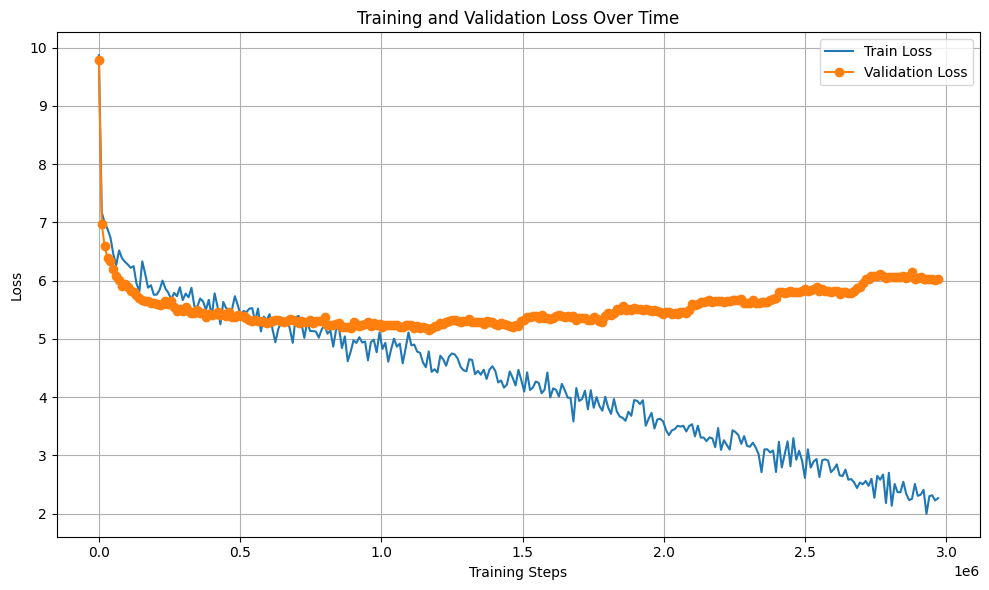

In [21]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, track_tokens_seen, eval_freq=20):
    # Compute x-axis (training steps)
    steps = list(range(0, eval_freq * len(val_losses), eval_freq))

    plt.figure(figsize=(10, 6))
    #plt.plot(range(len(train_losses)), train_losses, label='Train Loss', alpha=0.7)
    #plt.plot(steps, val_losses, label='Validation Loss', marker='o')
    plt.plot(track_tokens_seen, train_losses, label='Train Loss')
    plt.plot(track_tokens_seen, val_losses, label='Validation Loss', marker='o')

    plt.title("Training and Validation Loss Over Time")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_losses(train_losses, val_losses, track_tokens_seen, eval_freq=20)


In [22]:
tokenizer = tiktoken.get_encoding("gpt2") # Load tokenizer

# Prompt
prompt = "The sky was clear"
token_ids = tokenizer.encode(prompt)
input_ids = torch.tensor([token_ids], dtype=torch.long).to(device)

# Generate
output_ids = model.generate(
    input_ids=input_ids,
    max_new_tokens=50,
    temperature=0.9,
    top_k=40,
    top_p=0.95,
    eos_token_id=tokenizer.eot_token  # or 50256
)

# Decode (tiktoken does not have decode with skip_special_tokens)
output_text = tokenizer.decode(output_ids[0].tolist())
print(output_text)


The sky was clear their waters. To the great
sound“What? Do you want to-ridden!’t want a man, eh?”


“Oh!”


“Ye; and pointing the car


In [ ]:
import json
import os

def save_custom_model(model, config, save_dir="custom_gpt_model"):
    """
    Save a custom PyTorch GPT model and its configuration.

    Args:
        model (torch.nn.Module): Your custom GPT model (e.g., GPTModel).
        config (dict): Configuration dictionary used to build the model.
        save_dir (str): Directory to save model files.
    """
    os.makedirs(save_dir, exist_ok=True)
    # Save model weights
    weights_path = os.path.join(save_dir, "model_weights.pt")
    torch.save(model.state_dict(), weights_path)
    
    # Save model config
    config_path = os.path.join(save_dir, "config.json")
    with open(config_path, "w") as f:
        json.dump(config, f, indent=4)
    
    print(f"Model and config saved to: {save_dir}")

save_custom_model(model, GPT_CONFIG_124M, save_dir="saved_gpt")
